In [9]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
from sklearn import linear_model
clf = linear_model.LinearRegression()
from scipy.stats import pearsonr
import statsmodels.api as sm
import pysal.lib as ps
from mgwr.gwr import GWR
from mgwr.sel_bw import Sel_BW
from scipy.linalg import toeplitz
import multiprocessing as mp

In [10]:
ds = xr.open_dataset('./alaska_data/EOF/olsdata.nc')
temp = ds.temp.values
prcp = ds.prcp.values
vpd = ds.vpd.values
lat = ds.lat.values
lon = ds.lon.values
ds.close()
ds = xr.open_dataset('./alaska_data/EOF/NIRPeak.nc')
nir = ds.Peak.values
ds.close()
ds = xr.open_dataset('./alaska_data/EOF/mask.nc')
mm = ds.mask.values
ds.close()
nir = np.where(mm, np.nan, nir[:,::-1].T)

In [4]:
mm1 = mm[::10,::10]

lon = np.arange(-168, -139.99, 0.1)
lat = np.arange(58.39, 71.3, 0.1)
lon, lat = np.meshgrid(lon,lat)
x = 130
y = 281

lon_tt = np.reshape(lon, (x*y), order='F')
lon_tt = np.ma.masked_array(lon_tt, mm1)
ocean = lon_tt.mask
land = ~ocean
lon_tt = lon_tt[land]

lat_tt = np.reshape(lat, (x*y), order='F')
lat_tt = np.ma.masked_array(lat_tt, mm1)
ocean = lat_tt.mask
land = ~ocean
lat_tt = lat_tt[land]

coords = list(zip(lon_tt, lat_tt))

In [5]:
x = 130
y = 281

temp_tt = np.reshape(temp[::10,::10], (x*y), order='F')
temp_tt = np.ma.masked_array(temp_tt, np.isnan(temp_tt))
ocean = temp_tt.mask
land = ~ocean
temp_tt = temp_tt[land]

prcp_tt = np.reshape(prcp[::10,::10], (x*y), order='F')
prcp_tt = np.ma.masked_array(prcp_tt, np.isnan(prcp_tt))
ocean = prcp_tt.mask
land = ~ocean
prcp_tt = prcp_tt[land]

vpd_tt = np.reshape(vpd[::10,::10], (x*y), order='F')
vpd_tt = np.ma.masked_array(vpd_tt, np.isnan(vpd_tt))
ocean = vpd_tt.mask
land = ~ocean
vpd_tt = vpd_tt[land]

nir_tt = np.reshape(nir[::10,::10], (x*y), order='F')
nir_tt = np.ma.masked_array(nir_tt, np.isnan(nir_tt))
ocean = nir_tt.mask
land = ~ocean
nir_tt = nir_tt[land]

In [6]:
X = np.concatenate((temp_tt.reshape((len(temp_tt),1)), prcp_tt.reshape((len(prcp_tt),1))), axis=1)
Y = np.array(nir_tt.reshape((-1,1)))

In [7]:
# GLS
ols_resid = sm.OLS(Y, np.array(X)).fit().resid
res_fit = sm.OLS(ols_resid[1:], ols_resid[:-1]).fit()
rho = res_fit.params
order = toeplitz(np.arange(21824))
sigma = rho**order

gls_model = sm.GLS(Y, np.array(X), sigma=sigma)
gls_results = gls_model.fit()
gls_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 GLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.683
Model:                            GLS   Adj. R-squared (uncentered):              0.683
Method:                 Least Squares   F-statistic:                          2.351e+04
Date:                Mon, 09 Dec 2019   Prob (F-statistic):                        0.00
Time:                        14:47:37   Log-Likelihood:                          17547.
No. Observations:               21824   AIC:                                 -3.509e+04
Df Residuals:                   21822   BIC:                                 -3.507e+04
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.0006   8.07e-06     70.526      0.000       0.001       0.001
x2          2.927e-05   4.09e-06      7.155      0.000    2.13e-05    3.73e-05
==============================================================================
Omnibus:                    68773.636   Durbin-Watson:                   2.015
Prob(Omnibus):                  0.000   Jarque-Bera (JB):      26975228765.174
Skew:                         -49.577   Prob(JB):                         0.00
Kurtosis:                    5448.641   Cond. No.                         6.81
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

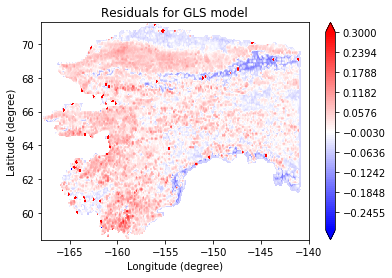

In [8]:
gls_resid = gls_results.resid
resid = np.ones(x*y) * -999.
resid[land] = gls_resid[:]
resid = np.ma.masked_values(np.reshape(resid, (x, y), order='F'), -999.)

plt.contourf(lon,lat,resid, cmap=plt.cm.bwr, levels=np.linspace(-.3,.3,100),extend='both')
plt.colorbar()
plt.xlabel('Longitude (degree)')
plt.ylabel('Latitude (degree)')
plt.title('Residuals for GLS model')
plt.savefig('./plot/gls_resid_tp.png')

In [12]:
%%time
gwr_results = GWR(coords, Y, np.array(X), 58.86,spherical=True, fixed=True).fit()
print(gwr_results.summary())

Model type                                                         Gaussian
Number of observations:                                               21824
Number of covariates:                                                     3

Global Regression Results
---------------------------------------------------------------------------
Residual sum of squares:                                            256.660
Log-likelihood:                                                   17515.257
AIC:                                                             -35024.513
AICc:                                                            -35022.512
BIC:                                                            -217751.836
R2:                                                                   0.013
Adj. R2:                                                              0.013

Variable                              Est.         SE  t(Est/SE)    p-value
------------------------------- ---------- ---------- ------

In [14]:
r2 = gwr_results.localR2

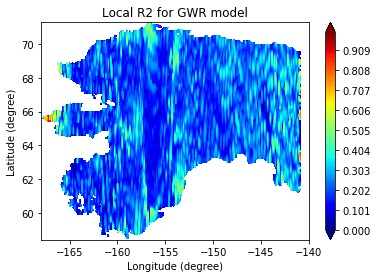

In [25]:
rr2 = np.ones(x*y) * -999.
rr2[land] = r2[:,0]
rr2 = np.ma.masked_values(np.reshape(rr2, (x, y), order='F'), -999.)

lon = np.arange(-168, -139.99, 0.1)
lat = np.arange(58.39, 71.3, 0.1)
lon, lat = np.meshgrid(lon,lat)
plt.contourf(lon,lat,rr2, cmap=plt.cm.jet, levels=np.linspace(0,1,100),extend='both')
plt.colorbar()
plt.xlabel('Longitude (degree)')
plt.ylabel('Latitude (degree)')
plt.title('Local R2 for GWR model')
plt.savefig('./plot/gwr_r2.png')

In [26]:
params = gwr_results.params
est = params[:,0] + params[:,1] * X[:,0] + params[:,2] * X[:,1]

Text(0.5, 1.0, 'Residuals for GWR model')

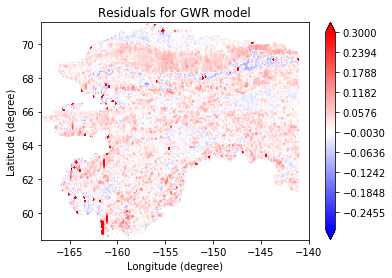

In [38]:
resid = np.ones(x*y) * -999.
resid[land] = Y[:,0] - est
resid = np.ma.masked_values(np.reshape(resid, (x, y), order='F'), -999.)

lon = np.arange(-168, -139.99, 0.1)
lat = np.arange(58.39, 71.3, 0.1)
lon, lat = np.meshgrid(lon,lat)
plt.contourf(lon,lat,resid, cmap=plt.cm.bwr, levels=np.linspace(-.3,.3,100),extend='both')
plt.colorbar()
plt.xlabel('Longitude (degree)')
plt.ylabel('Latitude (degree)')
plt.title('Residuals for GWR model')
# plt.savefig('./plot/gwr_r2.png')

In [33]:
est.shape

(21824,)